In [ ]:
# Using SWAN release 99
# pip install --user particle

In [1]:
import uproot
import uproot_methods
import numpy as np
import matplotlib.pyplot as plt 
import awkward
from os.path import splitext,exists
from particle import Particle

pileup = 50 
proton_xi_res = 0.02 # proton resolution
xi_min = 0.015 # min xi acceptance for pileup
xi_max = 0.15  # max xi acceptance for pileup
p_double = 8.8E-5 # probability of having a double tag pileup event (central-diffractive or single-diffractive x2)
p_single = 0.015 # probability of having a single tag pileup event (single-diffractive x2)

# Prepare dataset as signal or background
def prepDelphesDataset(isSignal=True, isTtbar=False, filename="", addPU = True):
    computeDecayType=False
    print("Loading file:",filename)
    file = uproot.open(filename)
    tree = file["Delphes"]
    # Pick only the needed branches
    branchSelection = ["Particle.PID","Particle.Status","Particle.M*","Particle.P*","Particle.E*",
                       "*Jet.PT","*Jet.Eta","*Jet.Phi","*Jet.Mass","*Jet.BTag",
                       "MissingET.MET","MissingET.Phi",
                       "Electron.PT","Electron.Eta","Electron.Phi",
                       "Muon.PT","Muon.Eta","Muon.Phi",
                       "*_size"]
    events = tree.arrays(branchSelection,namedecode="utf-8")
    events["BJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == True)])
    events["NonBJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == False)])
    
    n_events=len(events["Particle.PID"]) # n_events (updated along the way)
    initial_n_events=len(events["Particle.PID"]) # initial n_events
    print("Analyzing ",initial_n_events,"events...")
    
    if isTtbar | isSignal:
            print("Preparing ttbar variables...")
            # Select the gen level tops
            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            before_n = len(events["Particle.PID"])
            # Remove events with more than one gen ttbar (apparently it can happen)
            good_genTops = [len(i) == 1 and len(j) == 1 for i,j in zip(events["Particle.Px"][gen_top1_sel],events["Particle.Px"][gen_top2_sel])]
            for key in events:
                    events[key] = events[key][good_genTops]
            n_events=len(events["Particle.PID"])
            after_n = len(events["Particle.PID"])
            print("Removed {}% of the events because of weird gen ttbar system".format(100*(before_n-after_n)/initial_n_events))

            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            events["gen_top1"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top1_sel],events["Particle.Py"][gen_top1_sel],events["Particle.Pz"][gen_top1_sel],events["Particle.E"][gen_top1_sel]).flatten()
            events["gen_top2"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top2_sel],events["Particle.Py"][gen_top2_sel],events["Particle.Pz"][gen_top2_sel],events["Particle.E"][gen_top2_sel]).flatten()
            events["gen_m_ttbar"] = (events["gen_top1"]+events["gen_top2"]).mass
            print("Done.")
            if computeDecayType:
                decayFilename = splitext(filename)[0]+"_decayChannel.npy"
                if exists(decayFilename):
                    print("Loading decay channels from",decayFilename)
                    events["decay_channel"] = np.load(decayFilename,allow_pickle='TRUE')
                    print("Done.")
                else:
                    print("Computing ttbar decay type... this will take a while")
                    # Machinery to reconstruct the decay type
                    top_decay = []
                    for event_n in range(n_events):
                        top_decay.append([0,0])
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == 24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != 24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][0] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][0] += -top_decay_PID
                    print("I'm halfway through")
                    for event_n in range(n_events):
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == -24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != -24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][1] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][1] += -top_decay_PID
                    # Print decay fractions
                    n_lep = 0
                    n_semilep = 0
                    n_had = 0
                    decay_channel=[]
                    for event_n in range(n_events):
                        if top_decay[event_n][0] > 1000 and top_decay[event_n][1] > 1000:
                            decay_channel.append("lep")
                        elif top_decay[event_n][0] > 1000 or top_decay[event_n][1] > 1000:
                            decay_channel.append("semilep")
                        else:
                            decay_channel.append("had")
                    events["decay_channel"] = np.array(decay_channel)
                    print("Done.")
                    np.save(decayFilename, events["decay_channel"])
                    print("Saved decay channel in",decayFilename)
                n_lep = np.count_nonzero(events["decay_channel"] == "lep")
                n_semilep = np.count_nonzero(events["decay_channel"] == "semilep")
                n_had = np.count_nonzero(events["decay_channel"] == "had") 
                print("\tFully leptonic fraction:",n_lep*100/n_events,"%")
                print("\tSemileptonic fraction:",n_semilep*100/n_events,"%")
                print("\tHadronic fraction:",n_had*100/n_events,"%")
            
    if isSignal:
        print("Creating gen variables...")
        # Reconstruct the gen level xi
        gen_P_pos_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] > 3000) & (events["Particle.Status"] == 1)
        events["gen_xi_pos"] = 1 - events["Particle.E"][gen_P_pos_sel]/7000.
        gen_P_neg_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] < -3000) & (events["Particle.Status"] == 1)
        events["gen_xi_neg"] = 1 - np.abs(events["Particle.E"][gen_P_neg_sel]/7000.)

        # Find events with out-of-range xi values and remove them
        counter = 0
        not_weird_xi = []
        for i in range(len(events["Particle.Pz"][gen_P_pos_sel])):
            if len(events["gen_xi_pos"][i]) > 0 and len(events["gen_xi_neg"][i]) > 0:
                if events["gen_xi_pos"][i] > 0.15 or events["gen_xi_pos"][i] < 0.02 or events["gen_xi_neg"][i] > 0.15 or events["gen_xi_neg"][i] < 0.02:
                    counter += 1
                    not_weird_xi.append(False)
                else:
                    not_weird_xi.append(True)
            else:
                counter += 1
                not_weird_xi.append(False)
        print("Found {:.1f}% weird xi events".format(counter/n_events*100))
        for key in events:
                events[key] = events[key][not_weird_xi]
        n_events=len(events["Particle.PID"])
        events["gen_xi_pos"] = np.array(events["gen_xi_pos"].flatten())
        events["gen_xi_neg"] = np.array(events["gen_xi_neg"].flatten())
        # Compute the central mass and rapidity from the gen protons
        events["gen_m_protons"] = 14000 * np.sqrt(events["gen_xi_pos"] * events["gen_xi_neg"])
        events["gen_y_protons"] = 0.5 * np.log(events["gen_xi_pos"] / events["gen_xi_neg"])
        # Compute xi with smearing
        events["xi_pos"] = []
        events["xi_neg"] = []
        print("Done.")
        print("Smearing gen protons...")
        for i in range(n_events):
            events["xi_pos"].append([events["gen_xi_pos"][i] * np.random.normal(1,proton_xi_res)])
            events["xi_neg"].append([events["gen_xi_neg"][i] * np.random.normal(1,proton_xi_res)])
        print("Done.")
    else:
        events["xi_pos"] = []
        events["xi_neg"] = []
    if addPU:
        print("Adding pileup protons...")
        for i in range(n_events):
            events["xi_pos"].append([])
            events["xi_neg"].append([])
            puEvents = np.random.poisson(pileup)
            for j in range(puEvents):
                tag_rng = np.random.uniform()
                if tag_rng <= p_double:
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double) & (tag_rng <= p_double+p_single):
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double+p_single) & (tag_rng <= p_double+2*p_single):
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.        
    events["xi_pos"] = awkward.JaggedArray.fromiter(events["xi_pos"])
    events["xi_neg"] = awkward.JaggedArray.fromiter(events["xi_neg"])
    events["xi_pos_size"] = np.array([len(i) for i in events["xi_pos"]])
    events["xi_neg_size"] = np.array([len(i) for i in events["xi_neg"]])

    print("Done.")
    print("Finished!")
    return events

def plotWithRange(variable,nbins,xmin,xmax,xlabel="",histlabel="",axis=None,scalefactor=1,logscale=False):
    binWidth=(float)(xmax-xmin)/nbins
    ax = axis
    if axis==None:
        fig,ax = plt.subplots(1,figsize=(15,10))
        
    binEdges=[xmin+i*binWidth for i in range(nbins+1)]
    y, bin_edges,patches = ax.hist(variable, bins=binEdges,histtype="step",label=histlabel,weights = np.ones_like(variable) * scalefactor)
    plt.xlabel(xlabel,fontsize=20)
    plt.xlim([xmin,xmax])
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.',
        linestyle = 'None',
        drawstyle = 'steps-mid',
        color=patches[0].get_edgecolor()
    )
    if logscale:
        plt.yscale("log")
    if histlabel != "":
        plt.legend(fontsize=20)
    return ax

In [2]:
exampleSignal_1E12 = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/96/excl_anomTtbar_QED.root"
exampleSignal_1E11 = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/101/excl_anomTtbar_QED.root"
SM_ttbar = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_10/tag_1_delphes_events.root"

In [3]:
exampleSignal_1E12_ds = prepDelphesDataset(True,True,exampleSignal_1E12,addPU=False)
exampleSignal_1E11_ds = prepDelphesDataset(True,True,exampleSignal_1E11,addPU=False)
SM_ttbar_ds = prepDelphesDataset(False,True,SM_ttbar)

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/96/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.1% weird xi events
Done.
Smearing gen protons...
Done.
Done.
Finished!
Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/101/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.1% weird xi events
Done.
Smearing gen protons...
Done.
Done.
Finished!
Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_10/tag_1_delphes_events.root
Analyzing  50000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Adding pileup protons...
Done.
Finished!


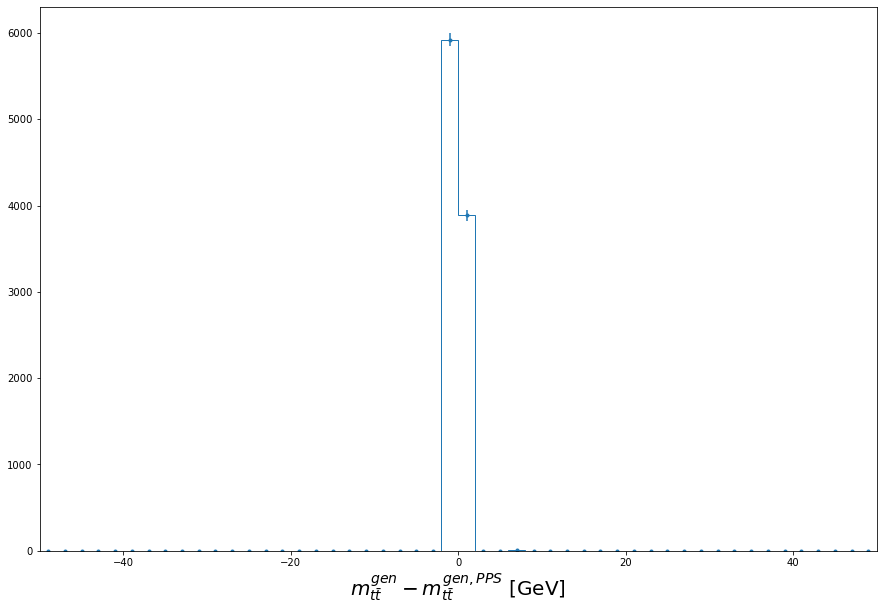

In [4]:
ax = plotWithRange(exampleSignal_1E12_ds["gen_m_ttbar"]-exampleSignal_1E12_ds["gen_m_protons"],50,-50,50,r"$m_{t\bar{t}}^{gen} - m_{t\bar{t}}^{gen,PPS}$ [GeV]")

<AxesSubplot:xlabel='$m_{t\\bar{t}}^{gen}$ [GeV]'>

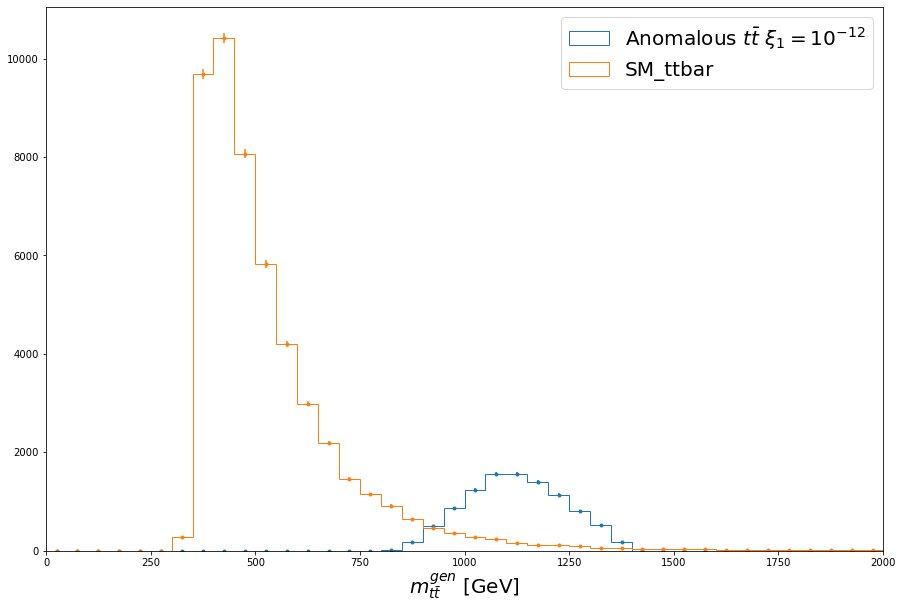

In [5]:
ax = plotWithRange(exampleSignal_1E12_ds["gen_m_ttbar"],40,0,2000,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(SM_ttbar_ds["gen_m_ttbar"],40,0,2000,r"$m_{t\bar{t}}^{gen}$ [GeV]","SM_ttbar",ax)

<AxesSubplot:xlabel='$p_{T}^{top,gen}$ [GeV]'>

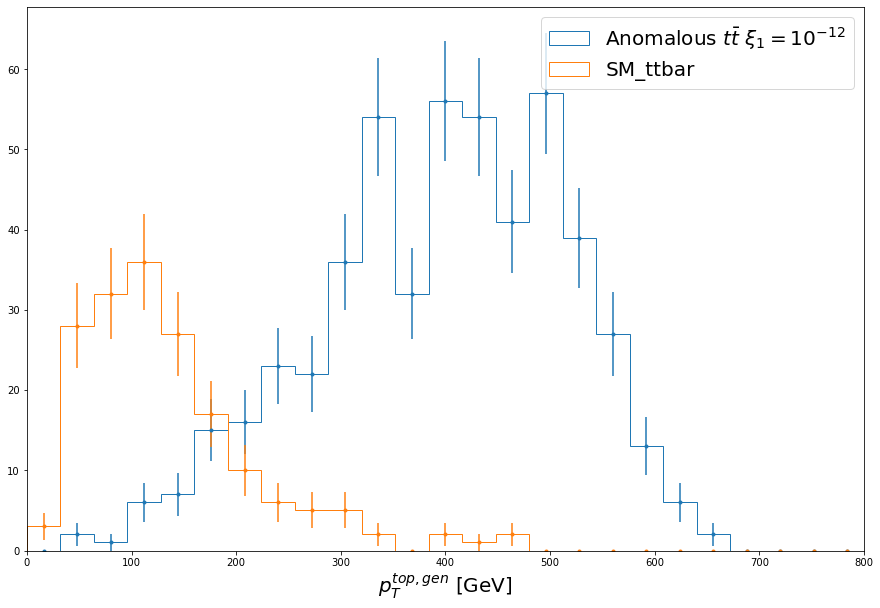

In [54]:
ax = plotWithRange([ t.pt for t in exampleSignal_1E12_ds["gen_top1"]],25,0,800,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([ t.pt for t in SM_ttbar_ds["gen_top1"]],25,0,800,r"$p_{T}^{top,gen}$ [GeV]","SM_ttbar",ax)

In [6]:
# Analyze semileptonic channel
def semilepAnalysisPreselection(dataset):
    ## Preselection
    mthan1Lep_sel = (dataset["Electron_size"] > 0) | (dataset["Muon_size"] > 0)
    mthan2BJets_sel = dataset["BJets_size"] >= 2
    mthan2NonBJets_sel = dataset["NonBJets_size"] >= 2
    mthan20gevMET_sel = (dataset["MissingET.MET"] > 20).flatten()
    mthan1ProtPerSide_sel = (dataset["xi_pos_size"] >= 1) & (dataset["xi_neg_size"] >= 1)
    semilep_presel = mthan1Lep_sel & mthan2BJets_sel & mthan2NonBJets_sel & mthan20gevMET_sel & mthan1ProtPerSide_sel

    print("Passing semilep preselection:", np.count_nonzero(semilep_presel),"({:.2f}%)".format(100.*np.count_nonzero(semilep_presel)/len(dataset["Jet.PT"])))
    for key in dataset:
        dataset[key] = dataset[key][semilep_presel]

    # Reconstruct ttbar system

    dataset["Lepton"] = np.array([])
    dataset["Neutrino"] = np.array([])
    dataset["BJet_1"] = np.array([])
    dataset["BJet_2"] = np.array([])
    dataset["Jet_1"] = np.array([])
    dataset["Jet_2"] = np.array([])
    for i in range(len(dataset["Electron_size"])):
        # Choose the highest PT lepton
        max_pt_e = 0
        max_pt_e_idx = -1
        max_pt_mu = 0
        max_pt_mu_idx = -1
        if dataset["Electron_size"][i] > 0:
            max_pt_e = dataset["Electron.PT"][i][0]
        if dataset["Muon_size"][i] > 0:
            max_pt_mu = dataset["Muon.PT"][i][0]
        if max_pt_e > max_pt_mu:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_e,dataset["Electron.Eta"][i][0],dataset["Electron.Phi"][i][0],Particle.from_pdgid(11).mass*1E-3)
        else:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_mu,dataset["Muon.Eta"][i][0],dataset["Muon.Phi"][i][0],Particle.from_pdgid(13).mass*1E-3)
        dataset["Lepton"] = np.append(dataset["Lepton"],lepton)
        # Assume MET has no longitudinal component (CAN BE IMPROVED)
        neutrino = uproot_methods.TLorentzVector.from_ptetaphim(dataset["MissingET.MET"][i][0],0,dataset["MissingET.Phi"][i][0],0)
        dataset["Neutrino"] = np.append(dataset["Neutrino"],neutrino)
        # Get the two most energetic BJets
        bjets_sel = dataset["Jet.BTag"] == True
        bjet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][0],dataset["Jet.Eta"][bjets_sel][i][0],dataset["Jet.Phi"][bjets_sel][i][0],dataset["Jet.Mass"][bjets_sel][i][0])
        bjet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][1],dataset["Jet.Eta"][bjets_sel][i][1],dataset["Jet.Phi"][bjets_sel][i][1],dataset["Jet.Mass"][bjets_sel][i][1])
        dataset["BJet_1"] = np.append(dataset["BJet_1"],bjet_1)
        dataset["BJet_2"] = np.append(dataset["BJet_2"],bjet_2)
        # Get the two most energetic NonBJets
        jets_sel = dataset["Jet.BTag"] == False
        jet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][0],dataset["Jet.Eta"][jets_sel][i][0],dataset["Jet.Phi"][jets_sel][i][0],dataset["Jet.Mass"][jets_sel][i][0])
        jet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][1],dataset["Jet.Eta"][jets_sel][i][1],dataset["Jet.Phi"][jets_sel][i][1],dataset["Jet.Mass"][jets_sel][i][1])
        dataset["Jet_1"] = np.append(dataset["Jet_1"],jet_1)
        dataset["Jet_2"] = np.append(dataset["Jet_2"],jet_2)
    dataset["m_ttbar"] = np.array([ttbar.mass for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    dataset["y_ttbar"] = np.array([ttbar.rapidity for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    
    # Compute mass from protons
    dataset["m_protons"] = np.array([14000 * np.sqrt(xi_pos[0] * xi_neg[0]) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    # Compute rapidity from protons
    dataset["y_protons"] = np.array([0.5 * np.log(xi_pos[0] / xi_neg[0]) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    
    # Compute the sum of the BJet energies
    dataset["BJet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet PT
    dataset["BJet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet acoplanarity
    dataset["BJet_acoplanarity"] = np.array([np.abs(1-(j1.phi-j2.phi)/np.pi) for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    
    # Compute the sum of the non-BJet energies
    dataset["Jet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])
    # Compute the sum of the non-BJet PT
    dataset["Jet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])

    return dataset

In [7]:
lumi_tot = 300. # 1/fb
exampleSignal_1E12_semilep_presel_ds = semilepAnalysisPreselection(exampleSignal_1E12_ds)
exampleSignal_1E11_semilep_presel_ds = semilepAnalysisPreselection(exampleSignal_1E11_ds)
SM_ttbar_semilep_presel_ds = semilepAnalysisPreselection(SM_ttbar_ds)

Passing semilep preselection: 509 (5.15%)
Passing semilep preselection: 477 (4.83%)
Passing semilep preselection: 920 (1.84%)


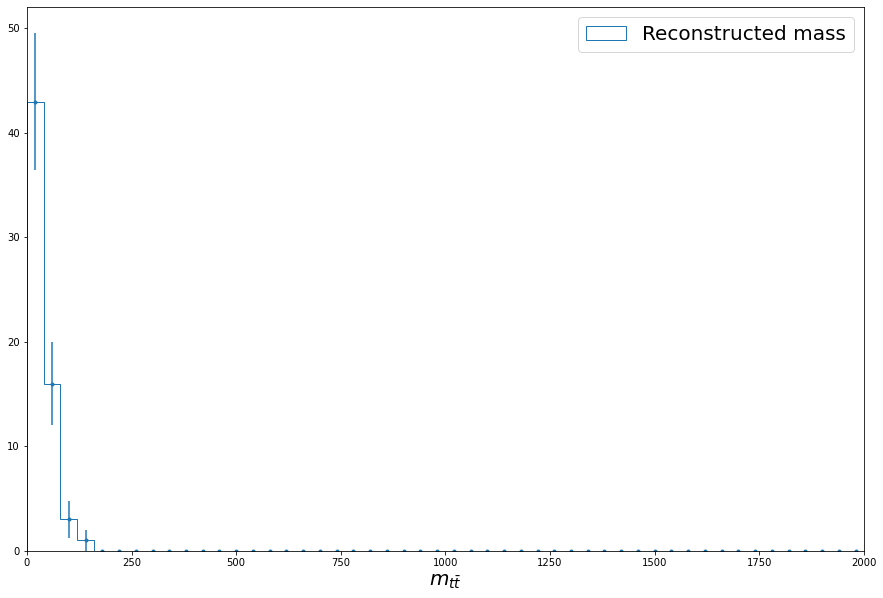

In [9]:
exampleSignal_1E12_xsec = 4.8100636966195363E-006 * 1e+3 #fb
exampleSignal_1E11_xsec = 4.8100636966195515E-004 * 1e+3 #fb
SM_ttbar_xsec = 832 * 1e+3 #fb

exampleSignal_1E12_sf = lumi_tot * exampleSignal_1E12_xsec / len(exampleSignal_1E12_ds["Jet.PT"])
exampleSignal_1E11_sf = lumi_tot * exampleSignal_1E11_xsec / len(exampleSignal_1E11_ds["Jet.PT"])
SM_ttbar_sf = lumi_tot * SM_ttbar_xsec / len(SM_ttbar_ds["Jet.PT"])

ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$","Reconstructed mass")
#plotWithRange(exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$ [GeV]","Generated mass",ax)

<AxesSubplot:xlabel='$m_{t\\bar{t}}$'>

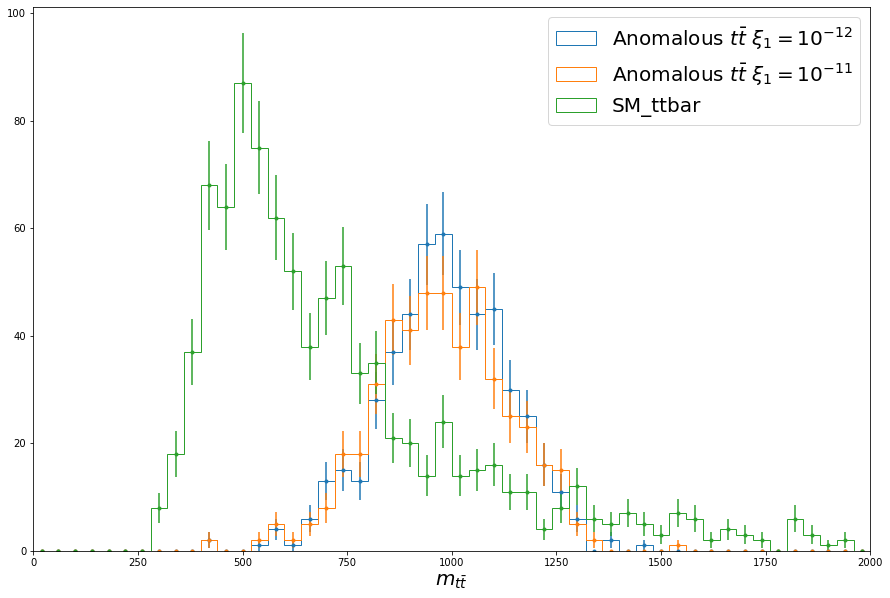

In [10]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\eta_{j1}$'>

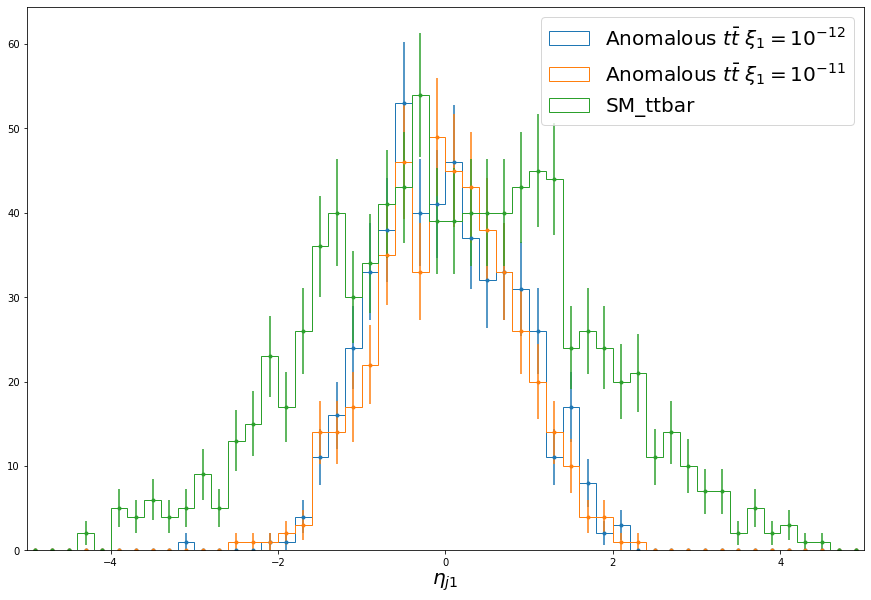

In [11]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_1"]],50,-5,5,r"$\eta_{j1}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\eta_{j2}$'>

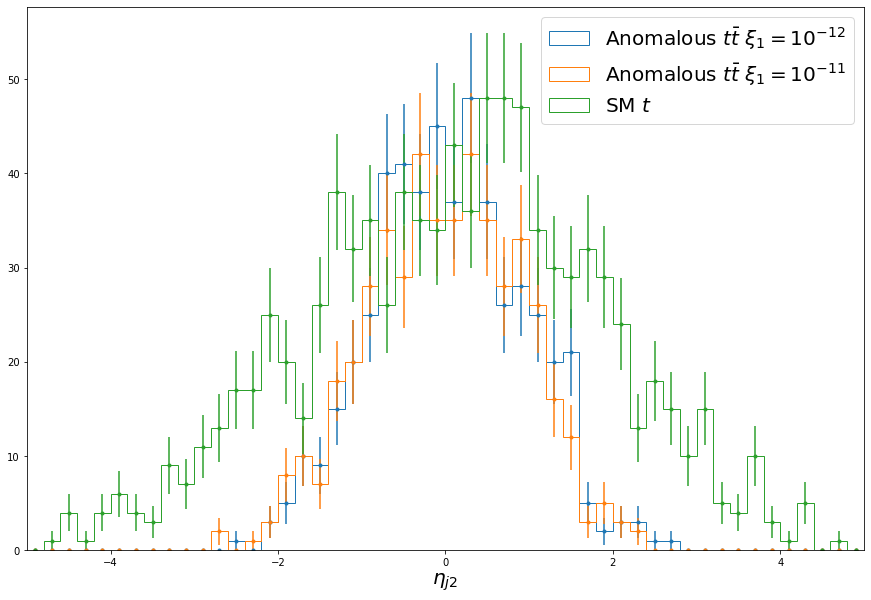

In [12]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_2"]],50,-5,5,r"$\eta_{j2}$","SM $t\bar{t}$",ax)

<AxesSubplot:xlabel='$\\eta_{Bj1}$'>

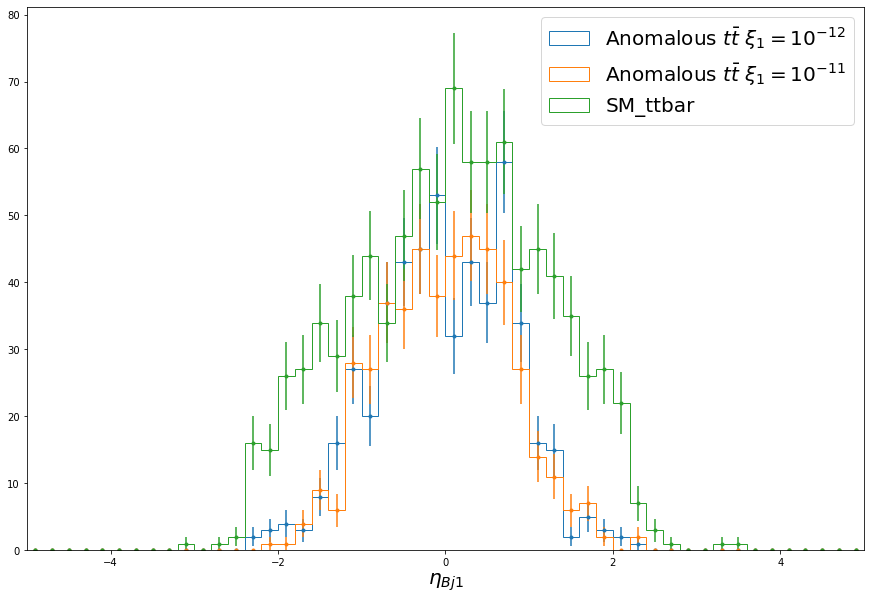

In [13]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_1"]],50,-5,5,r"$\eta_{Bj1}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\eta_{Bj2}$'>

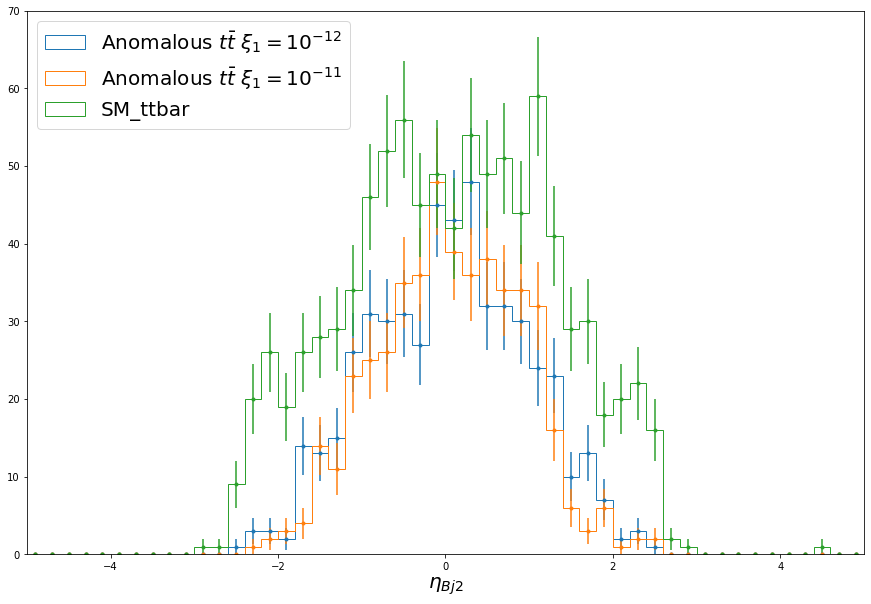

In [14]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_2"]],50,-5,5,r"$\eta_{Bj2}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\Delta m_{t\\bar{t}}$'>

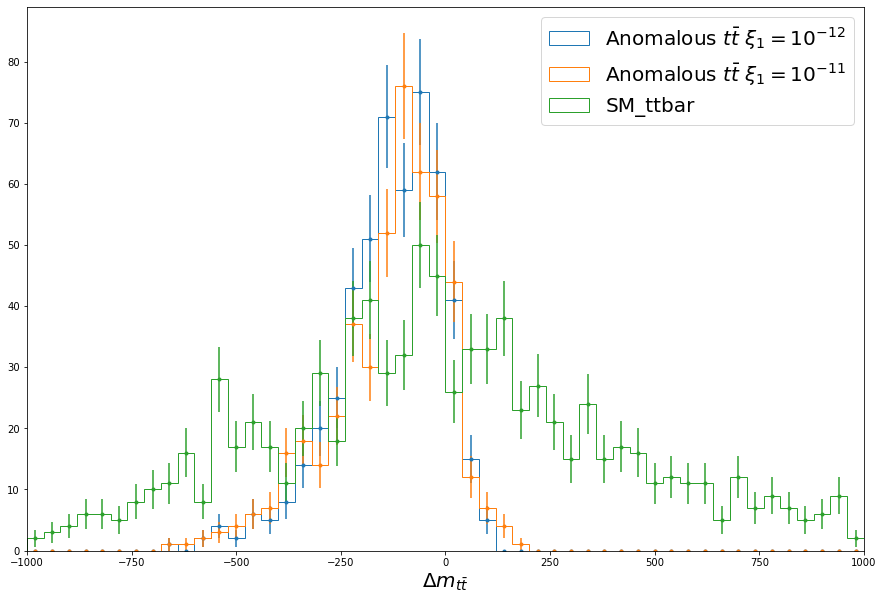

In [15]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["m_ttbar"]-exampleSignal_1E11_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["m_ttbar"]-SM_ttbar_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\Delta y_{t\\bar{t}}$'>

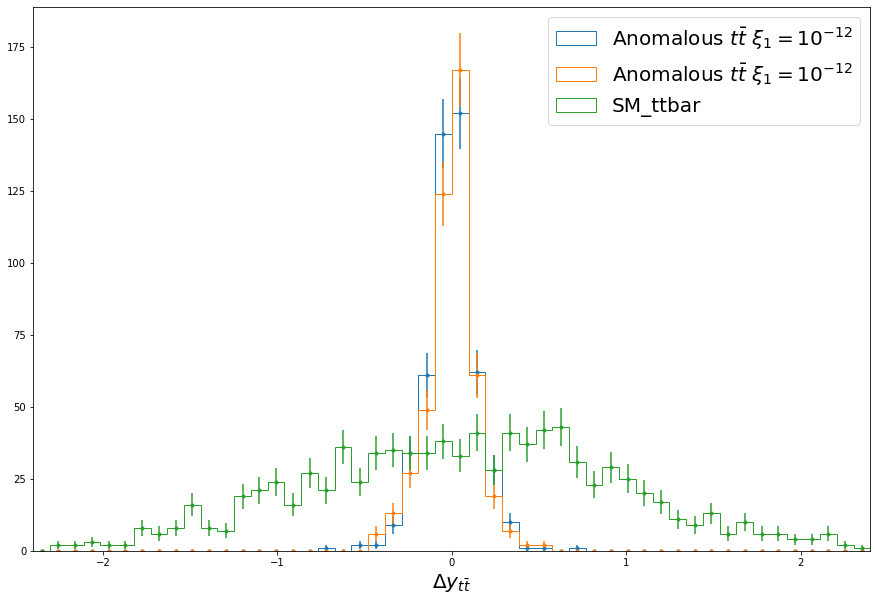

In [16]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["y_ttbar"]-exampleSignal_1E12_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["y_ttbar"]-exampleSignal_1E11_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["y_ttbar"]-SM_ttbar_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$p_{T}^{jet}$'>

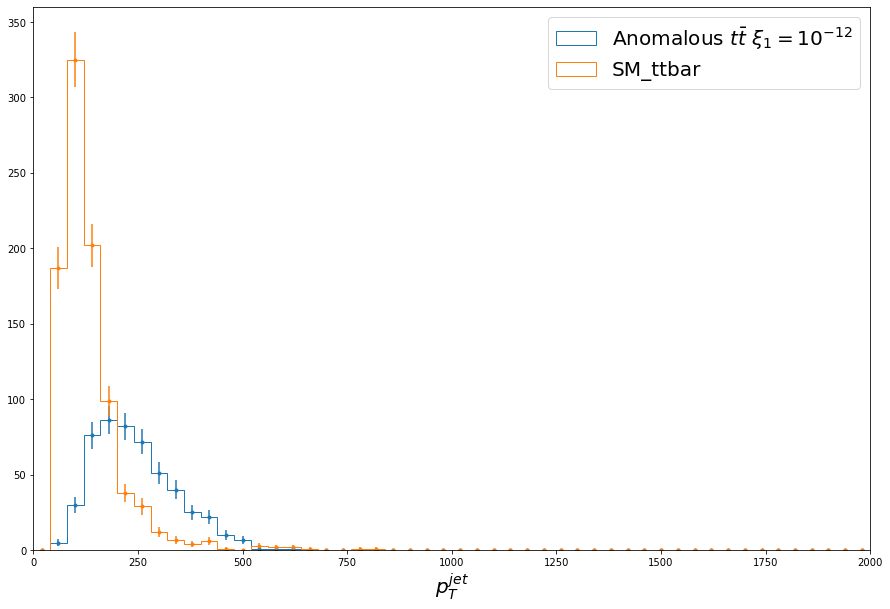

In [17]:
ax = plotWithRange([i[0] for i in exampleSignal_1E12_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange([i[0] for i in SM_ttbar_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$p_{T}^{jet}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$E_{BJets}^{tot}$'>

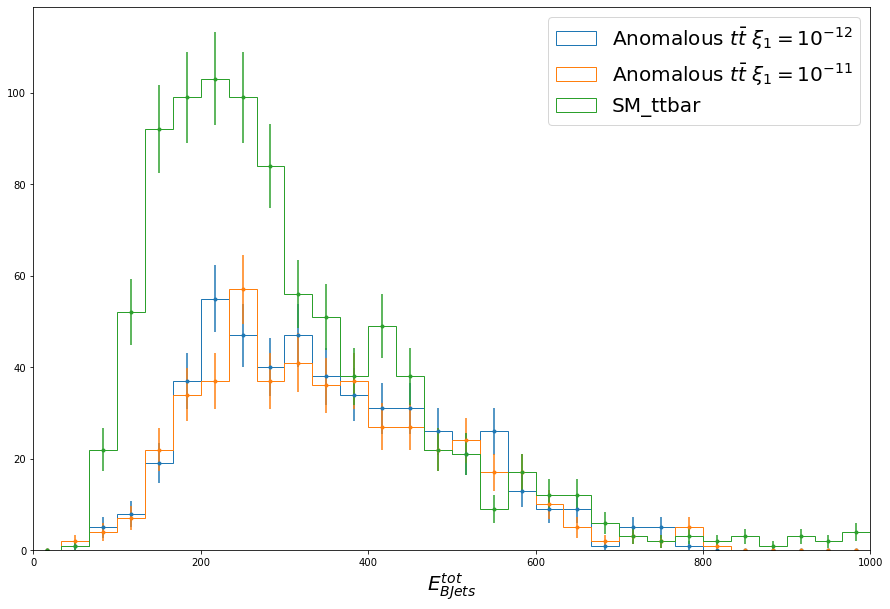

In [18]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_energy_tot"],30,0,1000,r"$E_{BJets}^{tot}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$E^{tot}_{Jets}$'>

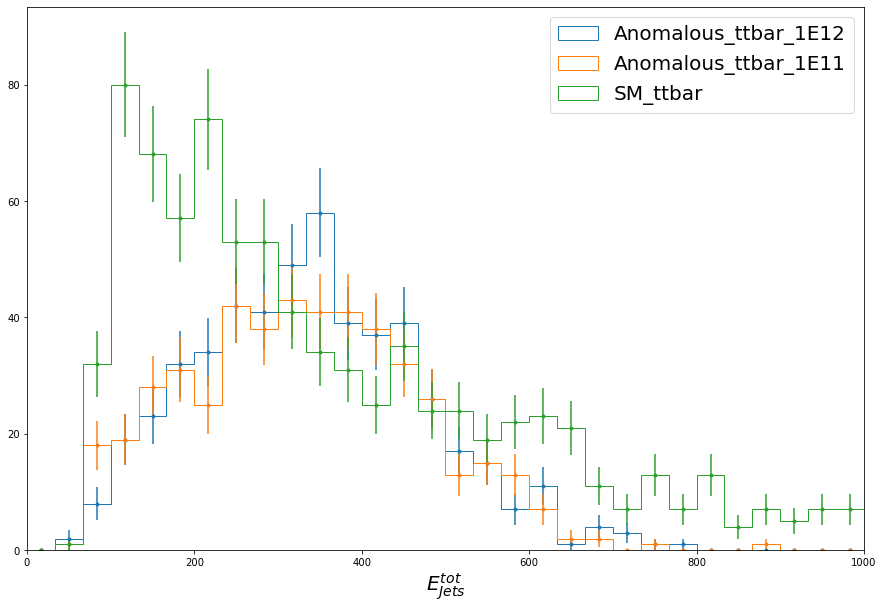

In [19]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_energy_tot"],30,0,1000,r"$E^{tot}_{Jets}$","SM_ttbar",ax)

<AxesSubplot:xlabel='BJets $P_{T}^{tot}$'>

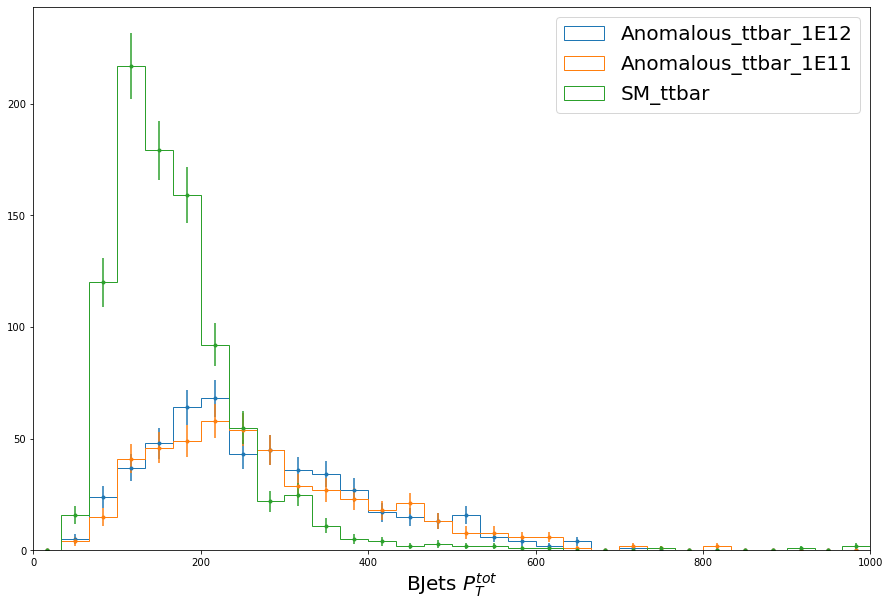

In [20]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"BJets $P_{T}^{tot}$","SM_ttbar",ax)

<AxesSubplot:xlabel='Jets $P_T^{tot}$'>

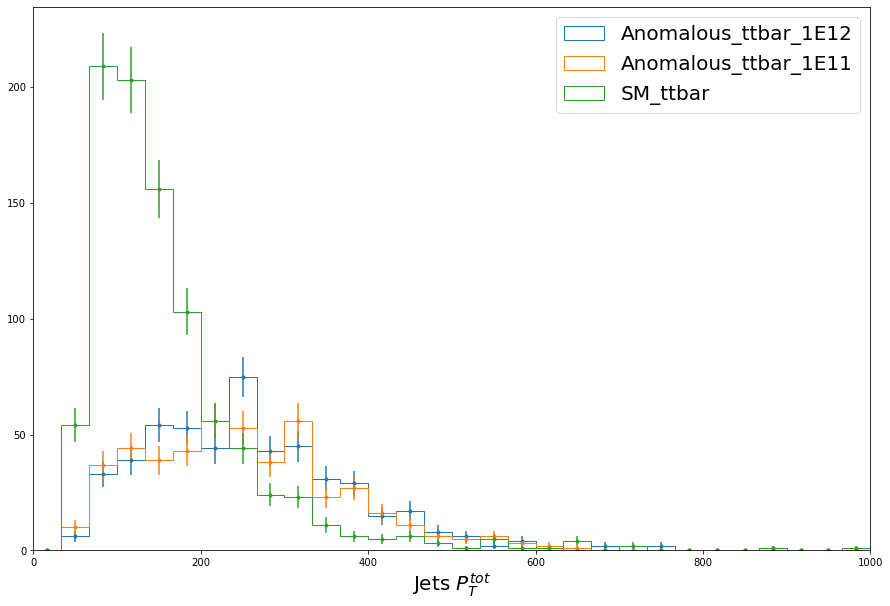

In [21]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"],30,0,1000,r"Jets $P_T^{tot}$","SM_ttbar",ax)

<AxesSubplot:xlabel='$H_T$'>

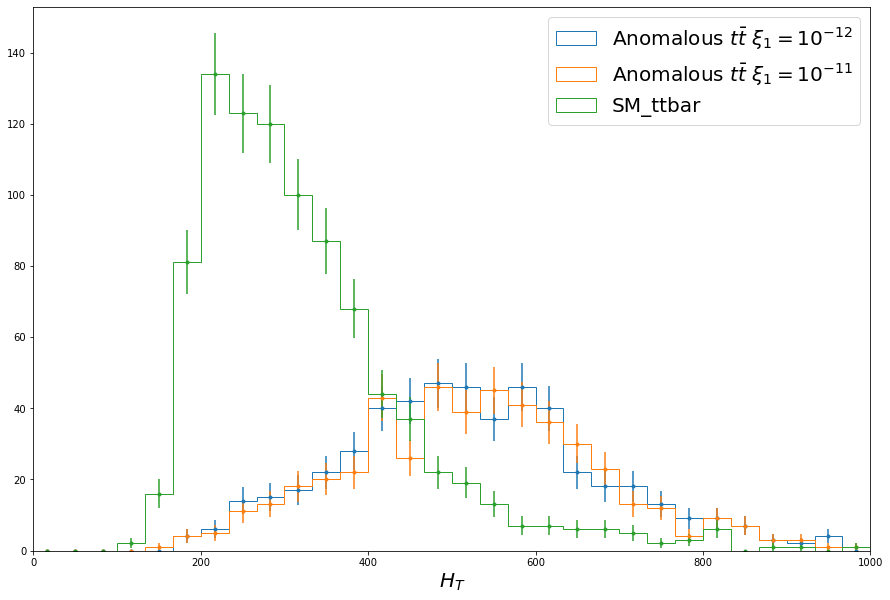

In [23]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"]+SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"$H_T$","SM_ttbar",ax)

In [24]:
def semilepAnalysisCentralSelection(dataset):     
    ht_sel = (dataset["Jet_pt_tot"]+dataset["BJet_pt_tot"]) > 400 # GeV
    m_tt_sel = dataset["m_ttbar"] > 750 # GeV
    semilep_central_sel = ht_sel & m_tt_sel
    print("Passing central selection:", np.count_nonzero(semilep_central_sel),"({:.2f}%)".format(100.*np.count_nonzero(semilep_central_sel)/len(dataset["Jet.PT"])))    

    for key in dataset:
        dataset[key] = dataset[key][semilep_central_sel]
        
    return dataset

In [25]:
exampleSignal_1E12_semilep_centralsel_ds = semilepAnalysisCentralSelection(exampleSignal_1E12_semilep_presel_ds)
exampleSignal_1E11_semilep_centralsel_ds = semilepAnalysisCentralSelection(exampleSignal_1E11_semilep_presel_ds)
SM_ttbar_semilep_centralsel_ds = semilepAnalysisCentralSelection(SM_ttbar_semilep_presel_ds)

Passing central selection: 391 (76.82%)
Passing central selection: 373 (78.20%)
Passing central selection: 158 (17.17%)


<AxesSubplot:xlabel='$H_T$'>

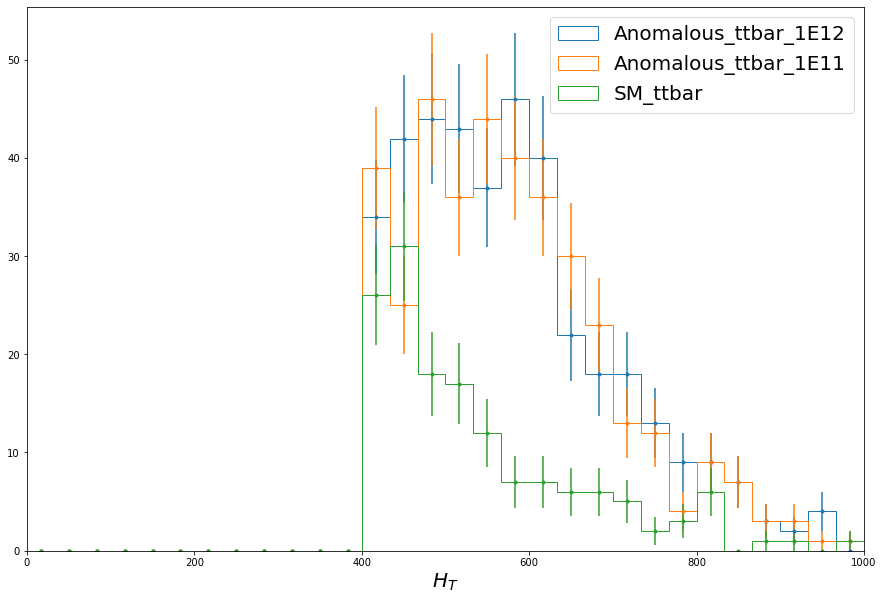

In [26]:
ax = plotWithRange(exampleSignal_1E12_semilep_centralsel_ds["Jet_pt_tot"]+exampleSignal_1E12_semilep_centralsel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_centralsel_ds["Jet_pt_tot"]+exampleSignal_1E11_semilep_centralsel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_centralsel_ds["Jet_pt_tot"]+SM_ttbar_semilep_centralsel_ds["BJet_pt_tot"],30,0,1000,r"$H_T$","SM_ttbar",ax)

<AxesSubplot:xlabel='$\\ell_{p_T}$'>

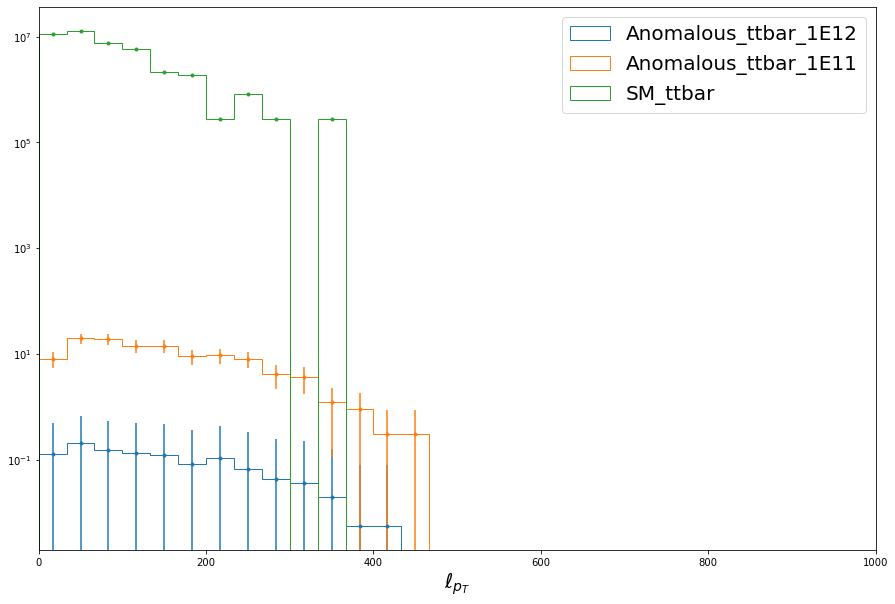

In [27]:
ax = plotWithRange([l.pt for l in exampleSignal_1E12_semilep_centralsel_ds["Lepton"]],30,0,1000,"","Anomalous_ttbar_1E12",scalefactor=exampleSignal_1E12_sf,logscale=True)
plotWithRange([l.pt for l in exampleSignal_1E11_semilep_centralsel_ds["Lepton"]],30,0,1000,"","Anomalous_ttbar_1E11",ax,exampleSignal_1E11_sf,logscale=True)
plotWithRange([l.pt for l in SM_ttbar_semilep_centralsel_ds["Lepton"]],30,0,1000,r"$\ell_{p_T}$","SM_ttbar",ax,SM_ttbar_sf,logscale=True)

In [28]:
def semilepAnalysisProtonSelection(dataset):     
    mass_match_sel = (-250 < (dataset["m_ttbar"]-dataset["m_protons"])) & ((dataset["m_ttbar"]-dataset["m_protons"]) < 0) #GeV
    rapidity_match_sel = (-0.3 < (dataset["y_ttbar"]-dataset["y_protons"])) & ((dataset["y_ttbar"]-dataset["y_protons"]) < 0.3) #GeV
    semilep_proton_sel = mass_match_sel & rapidity_match_sel
    print("Passing proton selection:", np.count_nonzero(semilep_proton_sel),"({:.2f}%)".format(100.*np.count_nonzero(semilep_proton_sel)/len(dataset["Jet.PT"])))    

    for key in dataset:
        dataset[key] = dataset[key][semilep_proton_sel]
        
    return dataset

In [29]:
exampleSignal_1E12_semilep_fullsel_ds = semilepAnalysisProtonSelection(exampleSignal_1E12_semilep_centralsel_ds)
exampleSignal_1E11_semilep_fullsel_ds = semilepAnalysisProtonSelection(exampleSignal_1E11_semilep_centralsel_ds)
SM_ttbar_semilep_fullsel_ds = semilepAnalysisProtonSelection(SM_ttbar_semilep_centralsel_ds)

Passing proton selection: 303 (77.49%)
Passing proton selection: 272 (72.92%)
Passing proton selection: 2 (1.27%)


In [33]:
print(r"Events expected for",lumi_tot,"1/fb$:")
print("Xi1=1E12:",len(exampleSignal_1E12_semilep_fullsel_ds["Jet.PT"]) * exampleSignal_1E12_sf)
print("Xi1=1E11:",len(exampleSignal_1E11_semilep_fullsel_ds["Jet.PT"]) * exampleSignal_1E11_sf)
print("SM_ttbar:",len(SM_ttbar_semilep_fullsel_ds["Jet.PT"]) * SM_ttbar_sf)

Events expected for 300.0 1/fb$:
Xi1=1E12: 0.8590074460171234
Xi1=1E11: 82.28536638242252
SM_ttbar: 542608.695652174


<AxesSubplot:xlabel='$\\ell_{p_T}$'>

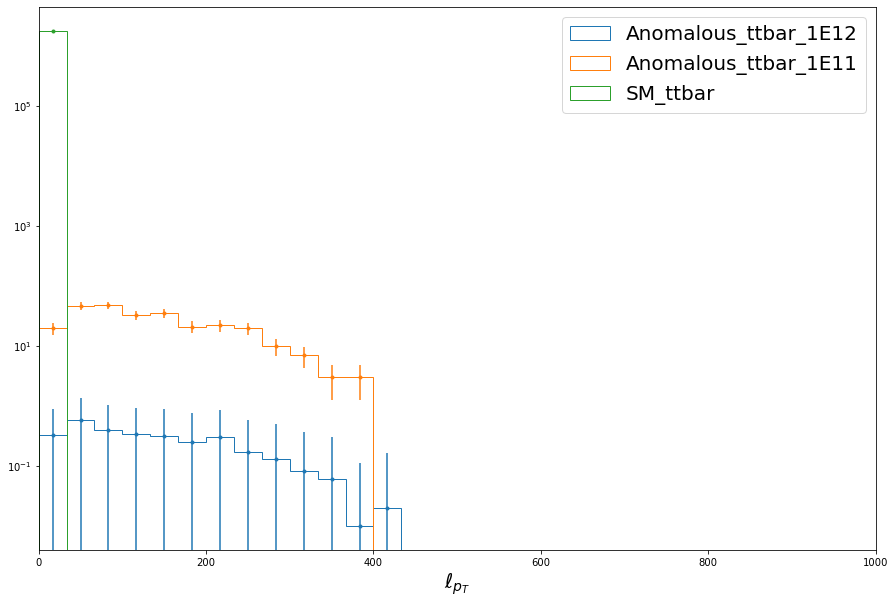

In [141]:
ax = plotWithRange([l.pt for l in exampleSignal_1E12_semilep_fullsel_ds["Lepton"]],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$",scalefactor=exampleSignal_1E12_sf,logscale=True)
plotWithRange([l.pt for l in exampleSignal_1E11_semilep_fullsel_ds["Lepton"]],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$",ax,exampleSignal_1E11_sf,logscale=True)
plotWithRange([l.pt for l in SM_ttbar_semilep_fullsel_ds["Lepton"]],30,0,1000,r"$\ell_{p_T}$","SM_ttbar",ax,SM_ttbar_sf,logscale=True)